# Project 4a - Molecular Simulation: Setting the stage and the two molecule case

## Due date TBD

We just finished simulating some very large things in the context of planetary motion.  However, you might be surprised that we can apply similar principles (including code, solvers, plotting tools, etc.) to the problem of simulating very small things, namely atoms and their interactions with one another in a homegeneous medium.

### The Lennard-Jones force
In conservative physical systems, force (which is a vector) can be derived from a scalar quantity called a potential (i.e. the potential energy).  Indeed, thinking about the gravitation problem, the force vector that you used to modify particle positions was in fact the negative gradient (with respect to each particle's position) of the potential energy that you computed when assessing energy conservation.  

Here we will use a different potential, called the Lennard-Jones potential, which has some much different properties from gravity.  The Lennard-Jones potential (between two particles indexed with $i$ and $j$) is given by
$$
u(r_{ij}) = 4\epsilon \left[ \left(\frac{\sigma}{|r_{ij}|}\right)^{12} - \left(\frac{\sigma}{|r_{ij}|}\right)^6 \right],
$$
where the distance is $r_{ij}^2 = \mathbf{r_{ij}}\cdot\mathbf{r_{ij}} = \left[(x_j - x_i)^2 + (y_j - y_i)^2\right]$ and  
$$
\mathbf{r}_{ij} = \mathbf{x}_j - \mathbf{x}_i = \begin{bmatrix} x_j - x_i \\ y_j - y_i \end{bmatrix}.
$$
To compute the force, we compute the negative gradient of the potential with respect to the positions $x_i$ and $y_i$, i.e. the derivative in both the $x$ and $y$ directions.
$$
F(\mathbf{x}_i,\mathbf{x}_j) = -F(\mathbf{x}_j,\mathbf{x}_i) = \nabla u(r_{ij}) = -\frac{24 \epsilon}{r_{ij}}\begin{bmatrix} 2\left(\frac{\sigma}{r_{ij}}\right)^{12} - \left(\frac{\sigma}{r_{ij}}\right)^{6} \end{bmatrix} \hat{\mathbf{r}}_{ij},
$$
where the hat indicates a vector that has been normalized to have a length of one, i.e. 
$$
\hat{\mathbf{r}}_{ij} = \frac{\mathbf{r}_{ij}}{r_{ij}}.
$$

In order to understand the behavior of the Lennard-Jones force, it as a function of distance $r$.  The $\hat{\mathbf{r}}$ at the end is just specifying the direction of the force, so ignore that part and just plot
$$
-\frac{24 \epsilon}{r}\begin{bmatrix} 2\left(\frac{\sigma}{r}\right)^{12} - \left(\frac{\sigma}{r}\right)^{6} \end{bmatrix}. 
$$
**Produce a line plot with $r$ on the bottom axis and the magnitude of the force on the vertical axis**.  To begin with do this for $\sigma=1$ and $\epsilon=1$.  The force is infinity at $r=0$, so don't plot it there: I suggest plotting from $r\in[\sigma,3\sigma]$ to see the most salient features.  **Write a short description of the most important features of this force.  In particular, describe what it does if two particles are close together, what it does if two particles are moderately far apart, and what it does if two particles are very far apart.  What do $\sigma$ and $\epsilon$ do?  At what distance(s) (in terms of $\sigma$) is the force zero? (indicate this latter quantity on your plot as well)**.  


In [2]:
import numpy as np
import matplotlib.pyplot as plt

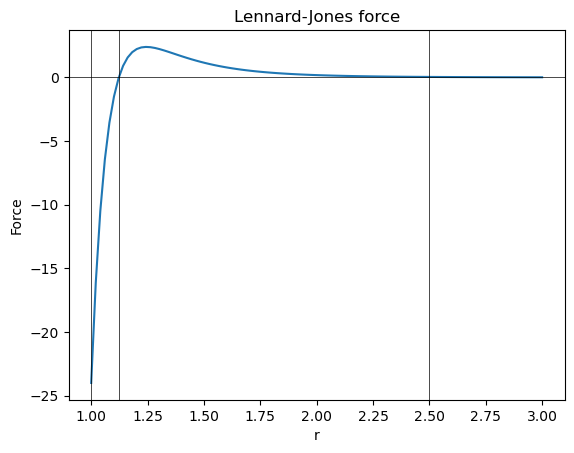

In [6]:
class LennardJones:
    def __init__(self, sigma, epsilon):
        self.sigma = sigma
        self.epsilon = epsilon
    def force(self, r):
        return -24*self.epsilon/r*(2*(self.sigma/r)**12 - (self.sigma/r)**6)

sigma = 1
epsilon = 1
lj = LennardJones(sigma, epsilon)
r = np.linspace(sigma, 3*sigma, 100)
plt.plot(r, lj.force(r))
plt.xlabel('r')
plt.ylabel('Force')
plt.title('Lennard-Jones force')
plt.axhline(0, color='black', lw=0.5)
plt.axvline(sigma, color='black', lw=0.5)
plt.axvline(2**(1/6)*sigma, color='black', lw=0.5)
plt.axvline(2.5*sigma, color='black', lw=0.5)
plt.show()

The plot above shows that, for short distances, the force between particles is repulsive, and for moderate distances, the force is attractive. Once a longer distance is reached, the force becomes zero.

### Implementing a problem class
Next, you'll need to **implement a problem class with the Lennard-Jones force.**  I suggest using your planetary gravitation code as a starting point.  This should be *very* similar to that: all that is needed is to swap out the gravitational force with Lennard-Jones.  If you haven't already, you'll want to ensure that this code can handle an arbitrary number of particles.  

In [5]:
class LennardJones:
    """ This is an example class for an ODE specification"""
    
    def __init__(self):
        pass
        
    def rhs(self,t,u):
        """
        Compute the right-hand side of the ODEs for positions and velocities.
        
        Parameters:
        - t: Time variable (not used, as the force is time-independent)
        - u: A flattened array containing positions and velocities of all particles
        
        Returns:
        - dudt: A flattened array of the derivatives of positions and velocities
        """
        # extract positions and velocities from the state vector
        positions = u[:2*self.N].reshape((self.N, 2)) # reshape for easier indexing in loop
        velocities = u[2*self.N:].reshape((self.N, 2))
        
        # initialize derivatives of positions (which are just the velocities)
        dxdt = velocities
        
        # initialize derivatives of velocities (accelerations) as zeros
        dvdt = np.zeros_like(velocities, dtype=float)
        
        # compute gravitational forces and resulting accelerations
        for i in range(self.N): # Loop over all particles
            for j in range(self.N): # Loop over all other particles
                if i != j: # Don't compute force of particle i on itself
                    r_ij = positions[j] - positions[i]  # Vector from particle i to particle j
                    r = np.linalg.norm(r_ij)  # Distance between particles i and j
                    # update acceleration of particle i due to particle j
                    dvdt[i] += -24*self.epsilon/r*(2*(self.sigma/r)**12 - (self.sigma/r)**6) / self.masses[i]
        
        # flatten the derivatives to match the structure of the input state vector [x1, y1, x2, y2, ... vx1, vy1, vx2, vy2, ...]
        dudt = np.concatenate([dxdt.flatten(), dvdt.flatten()])
        return dudt
        pass


**To test it, try it out on two particles**, each with unit mass, position vectors $\mathbf{x}_1 = [4,0]^T$ and $\mathbf{x}_2 = [6,0]^T$, and zero velocity.  Use $\sigma=1$ and $\epsilon=1$.  Once again, the Integrator class from previous exercises will work for this.  Because it's not so nice to always have this stuck inside the jupyter notebook, create a file inside the same directory as your notebook (call it ode_methods.py) and place the Integrator class (as well as any necessary import statements) inside it.  You can then access it from the notebook with

In [6]:
import ode_methods as om
Integrator = om.Integrator
mm 

In fact, why not put your time stepping schemes in there as well.  Here we'll start by using Euler-Cromer, so import it with something like

In [4]:
Cromer = om.Cromer

One python gotcha: if you update ode_methods.py, and then reimport, python will use a cached copy and you won't get the updated code.  You can either restart the interpretor or use

In [8]:
import importlib
importlib.reload(om)

<module 'ode_methods' from '/home/brinkerhoff/Teaching/Spring_2023/CSCI447/molecules/ode_methods.py'>

Before you actually perform the simulation, hypothesize with your team about what you think *ought* to happen in the above scenario (drawing a picture will be helpful).  

After successfully running the simulation, produce a plot (with nice axis labels) that addresses your hypothesis.  Does this align with your expectations? Try it again with some different initial conditions to see what happens.  I've found that one can produce some very beautiful flowerlike particle trajectories if you provide small, antisymmetric initial velocities in addition to the positions given above.

### Periodic boundary conditions
Ultimately, scientists would like to use molecular simulations to look at aggregate and macro-scale properties of collections of particles.  However, common objects (a coffee cup, for example) contain far more molecules than *any* computer could plausibly simulate at the level of detail that you've just implemented: the all pairs loop is simply too expensive.  Instead, we seek to perform simulations on small chunks of the material and hope that this is representative of the larger system.  For example, if we put 100 particles in a ten by ten box, we hope that the behavior there will be qualitatively similar to putting 10^12 particles in a 10^6 by 10^6 box.  However, this can only be true if we're careful about imposing boundaries.  If we don't, our small collection of particles will behave much differently than if they were sandwiched between many many other particles.  One way to simulate this latter effect is through the use of periodic boundary conditions.  This is a straightforward idea that is just a little bit tricky to implement.  The easy part is dealing with positions.  If we have a square periodic domain of size $L$, then anytime either position exceeds $L$, then we map it to $\mathbf{x} - L$.  Alternatively one could just write
$$
\mathbf{x}_i \leftarrow \mathbf{x} \% L,
$$
where we have used the modulo operator.  How do we fit this in with our integrator scheme?  There are many ways to do this, but my preferred method is to add an optional keyword argument to my integrator classes (I'll call it "callback" here), that accepts a class with method ".apply(u)" that operates on the state variable any time its modified.  For example:

In [9]:
class Cromer:
    def __init__(self,callbacks=[]):
        self.callbacks = callbacks
    
    def step(self,ode,t,dt,u_0):
        u_star = u_0 + dt*ode.rhs(t,u_0)
        for c in self.callbacks:
            u_star = c.apply(u_star)
        u_1 = u_0 + dt*ode.rhs(t,u_star)
        for c in self.callbacks:
            u_1 = c.apply(u_1)
        u_final = np.zeros_like(u_0)
        u_final[:ode.n_dof*2] = u_1[:ode.n_dof*2]
        u_final[ode.n_dof*2:] = u_star[ode.n_dof*2:]
        return u_final
    
class PBCCallback:
    def __init__(self,position_indices,L):
        """ Accepts a list of which degrees of freedom in u are positions 
        (which varies depending on how you organized them) as well as a 
        maximum domain size. """
        self.position_indices = position_indices
        self.L = L
                 
    def apply(self,u):
        # Set the positions to position modulo L
        u[self.position_indices] = u[self.position_indices] % L
        return u
    

You can use this callback scheme for other stuff too (imposing inequality constraints on a quantity that ought to remain positive for example), so its useful to have around.  

We're not done when it comes to implementing periodic boundary conditions.  We also need to account for the boundary conditions when we're computing distances between particles for the purpose of computing the Lennard-Jones force.  Gould listing 8.2 has the method in java.  Here, I've provided a function that computes the vector $\mathbf{r}_{ij}$ between two particle locations.  You can use it in your code, but make sure you understand how it works    

In [10]:
def periodic_distance(xi,xj,L):
    dx = xj[0] - xi[0]
    dy = xj[1] - xi[1]
    
    if dx>(0.5*L):
        dx -= L
    elif dx<(-0.5*L):
        dx += L
    else:
        pass
    
    if dy>(0.5*L):
        dy -= L
    elif dy<(-0.5*L):
        dy += L
    else:
        pass
    
    return np.array([dx,dy])

Modify your molecular dynamics problem class to accept a keyword argument that specifies whether to use the periodic distance or just the standard distance: your method should be able to do both.  

A good test case for whether periodic boundary conditions is the same 2-particle test case as above, but to specify the initial velocity of each particle as $\mathbf{v}=[1,1]$.  Everything should be exactly the same as before, except that your two particles will drift up and right before wrapping around to the lower left (while still exhibiting the same periodic "bouncing").  

### Animating the system
As we saw with the game of life, animating the dynamics of a system can be very helpful in understanding what's going on.  **Modify the animation code from the game of life to animate your molecular dynamics simulation**.  The modifications should be relatively minimal.  In particular, instead of updating an "imshow" raster plot, you'll update a scatter plot.  I've provided a skeleton, but its specialized to my scheme for organizing degrees of freedom.  You'll need to modify it to yours.


In [ ]:
import matplotlib.animation as anim
import matplotlib.pyplot as plt
%matplotlib notebook

fig,ax = plt.subplots()
fig.set_size_inches(4,4)

im = plt.plot(u[0,:n],u[0,n:2*n],'ro')
ax.set_xlim(0,L)
ax.set_ylim(0,L)

def animate(frame_number):

    im[0].set_xdata(u[frame_number,:n])
    im[0].set_ydata(u[frame_number,n:2*n])
    return im
    
animation = anim.FuncAnimation(fig, animate, frames=len(u), interval=1)

### Mess with stuff
Explore the behavior of this simulation.  In particular try adding additional particles.  Can you break the simulation?  Next time, we'll explore simulations with relatively large number of particles, and discover how this can elucidate systemic thermodynamical quantities. 